In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import decomposition

## Load image data

In [2]:
indiana_src = np.load("data/indianapines.npy")
indiana_gt = np.load("data/indianapines_gt.npy")
salinas_src = np.load("data/salinas.npy")
salinas_gt = np.load("data/salinas_gt.npy")

print("indiada    :", indiana_src.shape)
print("indiana_gt :", indiana_gt.shape)
print("salinas    :", salinas_src.shape)
print("salinas_gt :", salinas_gt.shape)

rgb_bands = [30, 15, 2]

indiada    : (145, 145, 200)
indiana_gt : (145, 145)
salinas    : (512, 217, 204)
salinas_gt : (512, 217)


In [3]:
indiana_dict = {
    "alfalfa" : 46,
    "corn-notill": 1428,
    "corn-mintill": 830,
    "corn": 237,
    "grass-pasture": 483,
    "grass-trees": 730,
    "grass-pasture-mowed": 28,
    "hay-windrowed": 478,
    "oats": 20,
    "soybean-notill": 972,
    "soybean-mintill": 2455,
    "soybean-clean": 593,
    "wheat": 205,
    "woods": 1265,
    "buildings-grass-trees-drives": 386,
    "stone-steel-towers": 93
}

salinas_dict = {
    "brocoli_green_weeds_1" : 2009,
    "brocoli_green_weeds_2" : 3726,
    "fallow" : 1976,
    "fallow_rough_plow" : 1394,
    "fallow_smooth" : 2678,
    "stubble" : 3959,
    "celery" : 3579,
    "grapes_untrained" : 11271,
    "soil_vinyard_develop" : 6203,
    "corn_senesced_green_weeds" : 3278,
    "lettuce_romaine_4wk" : 1068,
    "lettuce_romaine_5wk" : 1927,
    "lettuce_romaine_6wk" : 916,
    "lettuce_romaine_7wk" : 1070,
    "vinyard_untrained" : 7268,
    "vinyard_vertical_trellis" : 1807
}

### Normalization

In [4]:
# Could use : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

def normalizeImage(src_image, inPlace=False):
    if inPlace == True:
        image = src_image
    else:
        image = src_image.copy()

    image = image / image.max()
    return image

In [5]:
indiana = normalizeImage(indiana_src)

### Data preview

In [6]:
def pimpImageInRgb(image, rgb_bands):
    img_rgb = image.copy()[:,:,rgb_bands]
    
    rgb_min, rgb_max = np.percentile(img_rgb, (1, 99), axis=(0,1))

    new_image = img_rgb.copy()
    for i in range(rgb_min.size):
        new_image[:,:,i] = (img_rgb[:,:,i] - rgb_min[i]) / (rgb_max[i] - rgb_min[i])
    
    new_image[new_image < 0] = 0
    new_image[new_image > 1] = 1
    return new_image

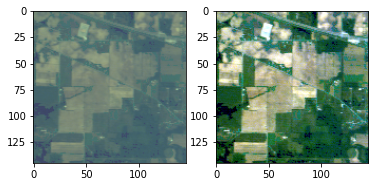

In [7]:
indiana_rgb = indiana[:,:,rgb_bands]
indiana_rgb_pimped = (pimpImageInRgb(indiana, rgb_bands))

plt.subplots()
plt.subplot(121)
plt.imshow(indiana_rgb)

plt.subplot(122)
plt.imshow(indiana_rgb_pimped)

### Make pca dim-reduction

In [8]:
def applyPca(image, /, varFactor=0.99, nbPCs=None):
    # Make data 2d
    row, col, dim = image.shape
    X = image.reshape((-1, dim))
    
    # Prepare pca
    pca_hsi = sklearn.decomposition.PCA()
    pca_hsi.fit(X)
    
    # Select best ammount in regards to desired variance factor
    var_cumsum = pca_hsi.explained_variance_ratio_.cumsum()
    if nbPCs is None:
        nbPCs = np.where(var_cumsum > varFactor)[0][0]
        print('%d components are necessary to retain %1.2f%% of the total variance'%((nbPCs+1),100*varFactor))
    else:
        print('%d components are retained'%(nbPCs))

    # Apply pca, keep desired ammount and reformat in 3d
    Xproj = pca_hsi.transform(X)
    hsi_proj = Xproj[:,:nbPCs].reshape((row,col,nbPCs))
    
    # Make the revert PCA to show the result
    Xproj_true = Xproj.copy()
    Xproj_true[:,nbPCs:] = 0
    hsi_proj_back = pca_hsi.inverse_transform(Xproj_true).reshape((row,col,dim))
    
    return hsi_proj, hsi_proj_back

25 components are necessary to retain 99.00% of the total variance


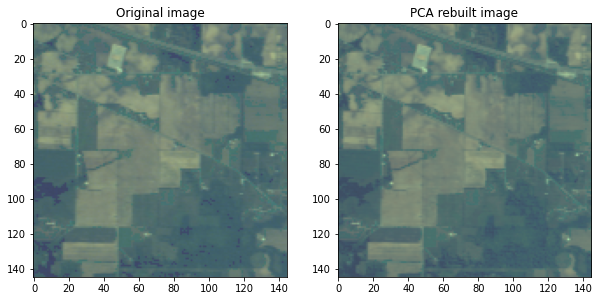

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title("Original image")
plt.imshow(indiana_rgb)
plt.subplot(122)
plt.title("PCA rebuilt image")
plt.imshow(applyPca(indiana)[1][:,:,rgb_bands])
plt.show()

### Image segmentation

#### Additional functions

In [10]:
import matplotlib.cm as cm

def random_lut(n_values):
    '''Build a random LUT for `n_values` elements (sequential integers).'''
    samples = np.linspace(0, 1, n_values)
    rng = np.random.default_rng(3)
    samples = rng.permutation(samples)
    colors = cm.hsv(samples, alpha=None, bytes=True)
    return colors[...,:3]

def show_image_seg(img, recolored, n_clusters):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Reference image")
    plt.subplot(1,2,2)
    plt.imshow(recolored.reshape(img.shape))
    plt.title(f"Segmented areas, {n_clusters} clusters")
    
def addCoordiangeImage(src_image, /, normalization_factor=255.0):
    image = src_image.copy() / normalization_factor
    nx, ny = image.shape[0], image.shape[1]
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    x = x / nx
    y = y / ny
    
    xv, yv = np.meshgrid(x,y)
    image = np.insert(image, 0, xv, axis=-1)
    image = np.insert(image, 0, yv, axis=-1)
    return image

In [11]:
def prepareImage(image, /, apply_pca=False, add_coords=False):
    if apply_pca:
        image, _ = applyPca(image)
    if add_coords:
        image = addCoordiangeImage(image)
    return image

def applySimpleClusterer(image, image_ref, n_clusters, clusterer):
    n_features = image.shape[-1]
    lut = random_lut(n_clusters)
    
    print(f"n_features: {n_features}")
    labels = clusterer.fit_predict(image.reshape((-1,n_features)))
    show_image_seg(image_ref, lut[labels], n_clusters)

#### Minibatch KMeans

25 components are necessary to retain 99.00% of the total variance
n_features: 26
n_features: 202


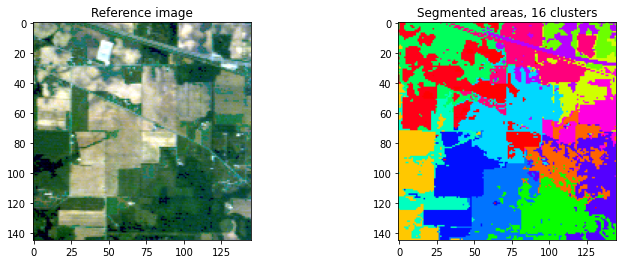

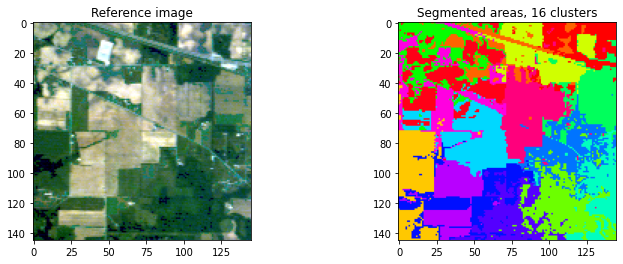

In [12]:
from sklearn.cluster import MiniBatchKMeans

def applyMiniBatchKmeans(image, image_ref, n_clusters, /, apply_pca=True):
    image = prepareImage(image.copy(), apply_pca=apply_pca, add_coords=True)
    applySimpleClusterer(image, image_ref, 16, MiniBatchKMeans(16, random_state=3))
    
applyMiniBatchKmeans(indiana, indiana_rgb_pimped, 16)
applyMiniBatchKmeans(indiana, indiana_rgb_pimped, 16, apply_pca=False)

#### Kmeans

25 components are necessary to retain 99.00% of the total variance
n_features: 26
n_features: 202


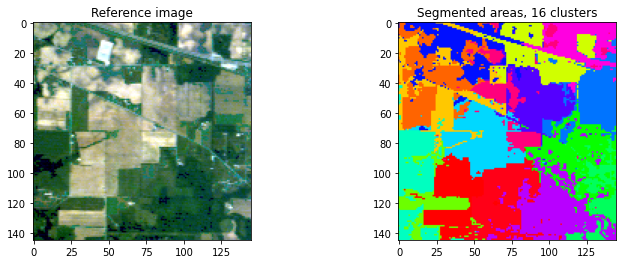

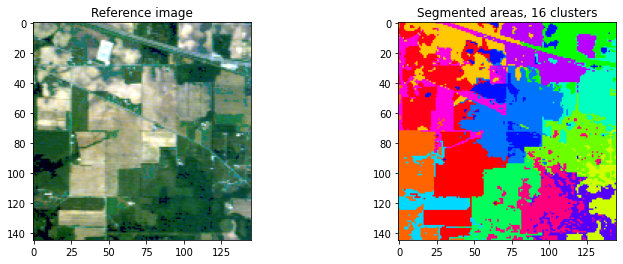

In [13]:
from sklearn.cluster import KMeans

def applyKmeans(image, image_ref, n_clusters, /, apply_pca=True):
    image = prepareImage(image.copy(), apply_pca=apply_pca, add_coords=True)
    applySimpleClusterer(image, image_ref, 16, KMeans(16, random_state=3))
    
applyKmeans(indiana, indiana_rgb_pimped, 16)
applyKmeans(indiana, indiana_rgb_pimped, 16, apply_pca=False)

#### Spectral clustering

In [14]:
from sklearn.cluster import SpectralClustering

def applySpectralClustering(image, image_ref, n_clusters):
    image = prepareImage(image.copy(), apply_pca=True, add_coords=True)
    applySimpleClusterer(image, image_ref, 16, SpectralClustering(16, random_state=3))
    
# My 16 gib machine could not handle the memory footprint which makes its usage quite complicated
# applySpectralClustering(indiana, indiana_rgb_pimped, 16)

#### Gaussian Mixture

25 components are necessary to retain 99.00% of the total variance
n_features: 26


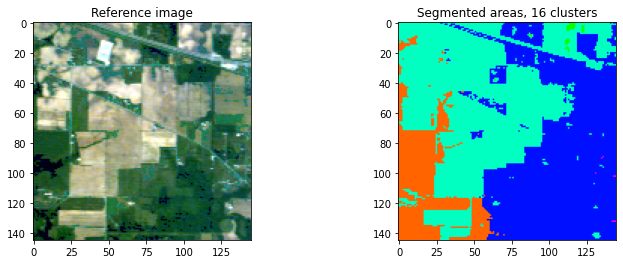

In [15]:
from sklearn.mixture import GaussianMixture

def applyGaussianMixture(image, image_ref, n_clusters):
    image = prepareImage(image.copy(), apply_pca=True, add_coords=True)
    applySimpleClusterer(image, image_ref, 16, GaussianMixture(16, random_state=3))
    
applyGaussianMixture(indiana, indiana_rgb_pimped, 16)

#### Meanshift

In [16]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def applyMeanShift(image, image_ref, n_clusters):
    image, _ = applyPca(image)
    img_seg = addCoordiangeImage(image, normalization_factor=1)
    n_features = img_seg.shape[-1]
    
    lut = random_lut(n_clusters)    
    band = estimate_bandwidth(img_seg.reshape((-1,n_features)), quantile=0.3, n_samples=None, random_state=0)
    clusterer = MeanShift(bandwidth=band, n_jobs=6, bin_seeding=True, min_bin_freq=50)
    
    print(f"n_features: {n_features}")
    labels = clusterer.fit_predict(img_seg.reshape((-1,n_features)))
    
    recolored = lut[labels]
    print(f"recolored.shape: {recolored.shape}")
    show_image_seg(image_ref, recolored, n_clusters)

25 components are necessary to retain 99.00% of the total variance
n_features: 26
recolored.shape: (21025, 3)


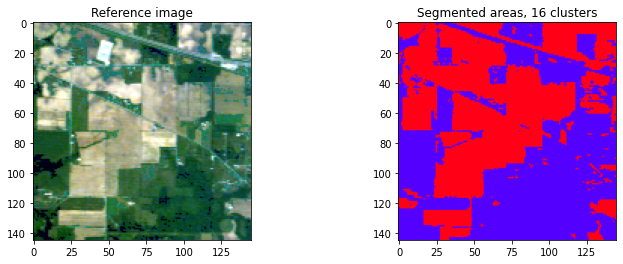

In [17]:
applyMeanShift(indiana, indiana_rgb_pimped, 16)

#### Birch

In [18]:
from sklearn.cluster import Birch

def applyBirch(image, image_ref, n_clusters):
    lut = random_lut(n_clusters)    
    image, _ = applyPca(image)

    clusterer = Birch(threshold=0.2, n_clusters=n_clusters)
    n_features = image.shape[-1]

    labels = clusterer.fit_predict(image.reshape((-1,n_features)))
    recolored = lut[labels]
    show_image_seg(image_ref, recolored, n_clusters)

25 components are necessary to retain 99.00% of the total variance


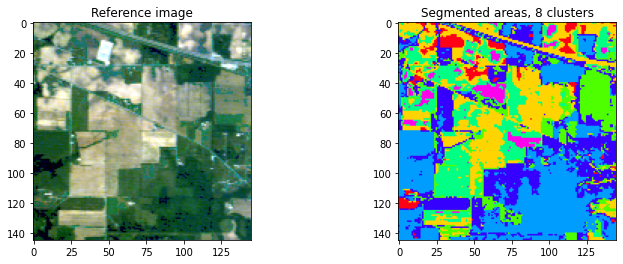

In [19]:
applyBirch(indiana, indiana_rgb_pimped, 8)